### This is a Tutorial Notebook to get started with CTO as soon as possible, without any frills
- We will be attempting to reproduce baseline result:
    - Training and testing models on pre 2020 data
        - Train, Valid: Trials with completion dates < 2018
        - Test: Trials with completion dates > 2018, but < 2020
    - Training and testing models on post 2020 data
        - Train, Valid: Trials with completion dates < 2020
        - Test: Trials with completion dates > 2020
- Prequisites:
    - pip install all requirements as in the requirements.txt
    - Navigate to https://zenodo.org/doi/10.5281/zenodo.11535960 (this link always resolves to the latest version), and download the latest version of CTO! 
    I downloaded the v0.3 labeling.zip, and placed it in the parent directory.
        ```bash
        wget https://zenodo.org/records/11608615/files/labeling.zip -P ../
        ```

In [9]:
# loading the zipped data
import numpy as np
import pandas as pd
import os
import glob
import zipfile

train_data_mode = 'pre'
if train_data_mode == 'pre':
    with zipfile.ZipFile('../labeling.zip', 'r') as zip_ref:
        # print(zip_ref.namelist())
        train_df = pd.read_csv(zip_ref.open('labeling/pre_post_2020/train_pre2020_dp.csv'))
        valid_df = pd.read_csv(zip_ref.open('labeling/pre_post_2020/valid_pre2020_dp.csv'))
        test_df = pd.read_csv(zip_ref.open('labeling/pre_post_2020/test_pre2020_dp.csv'))
elif train_data_mode == 'post':
    with zipfile.ZipFile('../labeling.zip', 'r') as zip_ref:
        # print(zip_ref.namelist())
        train_df = pd.read_csv(zip_ref.open('labeling/pre_post_2020/train_post2020_dp.csv'))
        valid_df = pd.read_csv(zip_ref.open('labeling/pre_post_2020/valid_post2020_dp.csv'))
        test_df = pd.read_csv(zip_ref.open('labeling/pre_post_2020/test_post2020_dp.csv'))

print(train_df.shape, valid_df.shape, test_df.shape)
# pre: (27245, 12) (6828, 12) (6151, 12)
# post: (32200, 12) (8024, 12) (12525, 12)

(27245, 12) (6828, 12) (6151, 12)


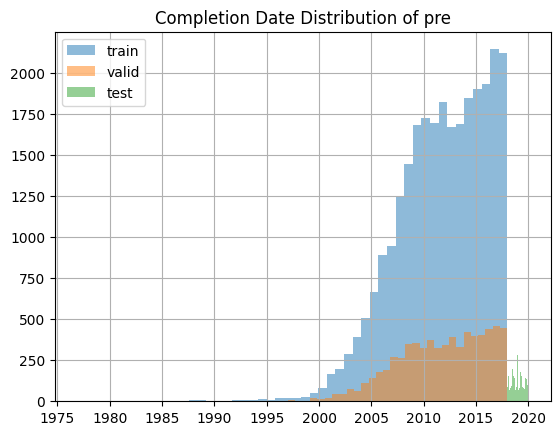

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# plot train, valid, and test completion date
train_df['completion_date'] = pd.to_datetime(train_df['completion_date'])
valid_df['completion_date'] = pd.to_datetime(valid_df['completion_date'])
test_df['completion_date'] = pd.to_datetime(test_df['completion_date'])

train_df['completion_date'].hist(bins=50, alpha=0.5, label='train')
valid_df['completion_date'].hist(bins=50, alpha=0.5, label='valid')
test_df['completion_date'].hist(bins=50, alpha=0.5, label='test')
plt.legend()
plt.title(f'Completion Date Distribution of {train_data_mode}')
plt.show()

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
# ============ preprocess by filling NAs and dropping duplocates ============
train_df = pd.concat([train_df, valid_df])
train_df.fillna('', inplace=True)
train_df.drop_duplicates(subset=['nctid'], inplace=True)
test_df.fillna('', inplace=True)
test_df.drop_duplicates(subset=['nctid'], inplace=True)

# ============ set features to phase + diseases + icdcodes + drugs + inclusion / exclusion criteria ============
train_df['features'] = train_df['phase'] + ' '  + train_df['diseases'] + ' '  + train_df['icdcodes'] + ' ' + train_df['drugs'] + ' ' + train_df['criteria']
test_df['features'] = test_df['phase'] + ' '  + test_df['diseases'] + ' '  + test_df['icdcodes'] + ' ' + test_df['drugs'] + ' ' + test_df['criteria']

# featurize the data
tfidf = TfidfVectorizer(max_features=2048, stop_words='english')
X_train = tfidf.fit_transform(train_df['features'])
X_test = tfidf.transform(test_df['features'])

In [12]:
# ============ define evalution ============
from sklearn.metrics import classification_report, f1_score, average_precision_score, roc_auc_score

def bootstrap_eval(y_true, y_pred, y_prob, num_samples=100):
    f1s = []
    aps = []
    rocs = []
    for _ in range(num_samples):
        indices = np.random.choice(len(y_true), len(y_true), replace=True)
        f1s.append(f1_score(y_true[indices], y_pred[indices]))
        aps.append(average_precision_score(y_true[indices], y_prob[indices]))
        rocs.append(roc_auc_score(y_true[indices], y_prob[indices]))
    return np.mean(f1s), np.std(f1s), np.mean(aps), np.std(aps), np.mean(rocs), np.std(rocs)

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
# from xgboost import XGBClassifier # pip install xgboost
from sklearn.neural_network import MLPClassifier

print(f'Model, Phase, F1, AP, ROC')
# for model_name in ['svm', 'xgboost', 'mlp', 'rf', 'lr', ]:
for model_name in ['svm', 'lr']: # use fastest models for testing
    if model_name == 'rf':
        model = RandomForestClassifier(n_estimators=300, random_state=0, max_depth=10, n_jobs=4)
    elif model_name == 'lr':
        model = LogisticRegression(max_iter=1000, random_state=0)
    elif model_name == 'svm':
        model = LinearSVC(dual="auto", max_iter=10000, random_state=0)
        model = CalibratedClassifierCV(model) 
        # model = SVC(kernel='linear', probability=True, random_state=0) # performs worse than the above
    elif model_name == 'xgboost':
        model = XGBClassifier(n_estimators=300, random_state=0, max_depth=10, n_jobs=4)
    elif model_name == 'mlp':
        model = MLPClassifier(hidden_layer_sizes=(64, 64), max_iter=2000, random_state=0)
    else:
        raise ValueError('Unknown model name')

    model.fit(X_train, train_df['label'])
    test_df['pred'] = model.predict(X_test)
    test_df['prob'] = model.predict_proba(X_test)[:, 1]

    for phase in ['phase 1', 'phase 2', 'phase 3']:
        test_df_subset = test_df[test_df['phase'].str.lower().str.contains(phase)]
        f1_mean, f1_std, ap_mean, ap_std, roc_mean, roc_std = bootstrap_eval(test_df_subset['label'].values, test_df_subset['pred'].values, test_df_subset['prob'].values)
        print(f"{phase}, {model_name}, {f1_mean:.3f}, {f1_std:.3f}, {ap_mean:.3f}, {ap_std:.3f}, {roc_mean:.3f}, {roc_std:.3f}")
    # combine all phases
    f1_mean, f1_std, ap_mean, ap_std, roc_mean, roc_std = bootstrap_eval(test_df['label'].values, test_df['pred'].values, test_df['prob'].values)
    print(f"all, {model_name}, {f1_mean:.3f}, {f1_std:.3f}, {ap_mean:.3f}, {ap_std:.3f}, {roc_mean:.3f}, {roc_std:.3f}")

Model, Phase, F1, AP, ROC
phase 1, svm, 0.744, 0.008, 0.634, 0.014, 0.558, 0.010
phase 2, svm, 0.863, 0.005, 0.796, 0.010, 0.573, 0.013
phase 3, svm, 0.909, 0.005, 0.862, 0.012, 0.560, 0.020
all, svm, 0.844, 0.004, 0.781, 0.008, 0.589, 0.009
phase 1, lr, 0.742, 0.009, 0.629, 0.015, 0.551, 0.012
phase 2, lr, 0.857, 0.005, 0.798, 0.012, 0.579, 0.013
phase 3, lr, 0.907, 0.005, 0.873, 0.011, 0.580, 0.019
all, lr, 0.841, 0.004, 0.784, 0.008, 0.592, 0.008


In [14]:
# ================== Results: pre 2020 split: training and validation has completion dates < 2018, test has completion dates > 2018 and < 2020 ==================
# Model, Phase, F1, AP, ROC
# phase 1, svm, 0.744, 0.008, 0.634, 0.014, 0.558, 0.010
# phase 2, svm, 0.863, 0.005, 0.796, 0.010, 0.573, 0.013
# phase 3, svm, 0.909, 0.005, 0.862, 0.012, 0.560, 0.020
# all, svm, 0.844, 0.004, 0.781, 0.008, 0.589, 0.009
# phase 1, lr, 0.742, 0.009, 0.629, 0.015, 0.551, 0.012
# phase 2, lr, 0.857, 0.005, 0.798, 0.012, 0.579, 0.013
# phase 3, lr, 0.907, 0.005, 0.873, 0.011, 0.580, 0.019
# all, lr, 0.841, 0.004, 0.784, 0.008, 0.592, 0.008

# ================== Results: post 2020 split: training and validation has completion dates < 2020, test has completion dates > 2020 ==================
# Model, Phase, F1, AP, ROC
# phase 1, svm, 0.665, 0.008, 0.516, 0.012, 0.528, 0.010
# phase 2, svm, 0.849, 0.004, 0.780, 0.008, 0.566, 0.008
# phase 3, svm, 0.911, 0.004, 0.862, 0.008, 0.561, 0.013
# all, svm, 0.826, 0.003, 0.761, 0.005, 0.587, 0.005
# phase 1, lr, 0.652, 0.006, 0.509, 0.010, 0.522, 0.009
# phase 2, lr, 0.836, 0.004, 0.778, 0.007, 0.567, 0.008
# phase 3, lr, 0.905, 0.004, 0.862, 0.008, 0.563, 0.015
# all, lr, 0.815, 0.003, 0.759, 0.005, 0.588, 0.006
